# Intent Classification using TF-IDF on SVM, Naive Bayes, KNN and LDA

In [1]:
# IMPORT PACKAGES

import pandas as pd
import nltk
import re
import numpy as np
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from keras import Sequential
from keras.layers import Dense
from keras import models
from keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
# LOAD THE DATA

intents = pd.read_csv('intent_data.csv', encoding = 'unicode_escape')
raw = intents
intents

,text,intent,entities/0/end,entities/0/entity,entities/0/start,entities/0/value
0,hello restaurants near Atlanta thanks,findRestaurantsByCity,30.0,city,23.0,Atlanta
1,restaurants in the area of Singapore,findRestaurantsByCity,36.0,city,27.0,Singapore
2,where to eat in the area of New York,findRestaurantsByCity,36.0,city,28.0,New York
3,cafes around San Francisco,findRestaurantsByCity,26.0,city,13.0,San Francisco
4,food near Singapore city,findRestaurantsByCity,19.0,city,10.0,Singapore
5,please searching for cafes near San Francisco ...,findRestaurantsByCity,45.0,city,32.0,San Francisco
6,cafes around Atlanta,findRestaurantsByCity,20.0,city,13.0,Atlanta
7,places to eat near San Francisco,findRestaurantsByCity,32.0,city,19.0,San Francisco
8,I'm looking for food around Atlanta thanks,findRestaurantsByCity,35.0,city,28.0,Atlanta
9,restaurants around Atlanta,findRestaurantsByCity,26.0,city,19.0,Atlanta


### Distribution of the Data Set

In [3]:
intents.groupby('intent').size()

intent
affirmative               50
bye                       50
findHotelsByCity         100
findRestaurantsByCity    100
greet                     50
negative                  50
dtype: int64

## Pre-Processing

In [4]:
# TOKENISATION

intents["text"] = intents["text"].apply(lambda x: nltk.word_tokenize(x))

In [5]:
intents["text"]

0            [hello, restaurants, near, Atlanta, thanks]
1            [restaurants, in, the, area, of, Singapore]
2         [where, to, eat, in, the, area, of, New, York]
3                        [cafes, around, San, Francisco]
4                          [food, near, Singapore, city]
5      [please, searching, for, cafes, near, San, Fra...
6                               [cafes, around, Atlanta]
7                [places, to, eat, near, San, Francisco]
8      [I, 'm, looking, for, food, around, Atlanta, t...
9                         [restaurants, around, Atlanta]
10     [please, Help, me, find, food, in, the, area, ...
11     [hey, there, pls, Help, me, find, where, to, e...
12     [please, searching, for, restaurants, located,...
13                          [food, near, San, Francisco]
14     [hello, please, find, restaurants, in, the, ar...
15     [pls, searching, for, places, to, eat, located...
16                  [food, in, the, area, of, Singapore]
17     [hello, Help, me, find, 

In [6]:
# LOWER CASE

def lowercase(tokens):
    tokens_new = []
    for token in tokens:
        t = token.lower()
        tokens_new.append(t)
    return tokens_new

intents["text"] = intents["text"].apply(lambda x: lowercase(x))
intents["text"]

0            [hello, restaurants, near, atlanta, thanks]
1            [restaurants, in, the, area, of, singapore]
2         [where, to, eat, in, the, area, of, new, york]
3                        [cafes, around, san, francisco]
4                          [food, near, singapore, city]
5      [please, searching, for, cafes, near, san, fra...
6                               [cafes, around, atlanta]
7                [places, to, eat, near, san, francisco]
8      [i, 'm, looking, for, food, around, atlanta, t...
9                         [restaurants, around, atlanta]
10     [please, help, me, find, food, in, the, area, ...
11     [hey, there, pls, help, me, find, where, to, e...
12     [please, searching, for, restaurants, located,...
13                          [food, near, san, francisco]
14     [hello, please, find, restaurants, in, the, ar...
15     [pls, searching, for, places, to, eat, located...
16                  [food, in, the, area, of, singapore]
17     [hello, help, me, find, 

In [7]:
# REMOVE PUNCTUATIONS AND SPECIAL CHARACTERS

def preprocess(text):
    clean_data = []
    for x in text: 
        new_text = re.sub('[^A-Za-z0-9]+', '', x) # remove punc.         
        if new_text != '':
            clean_data.append(new_text)
    return clean_data

intents["text"] = intents["text"].apply(lambda x: preprocess(x))
intents["text"]

0            [hello, restaurants, near, atlanta, thanks]
1            [restaurants, in, the, area, of, singapore]
2         [where, to, eat, in, the, area, of, new, york]
3                        [cafes, around, san, francisco]
4                          [food, near, singapore, city]
5      [please, searching, for, cafes, near, san, fra...
6                               [cafes, around, atlanta]
7                [places, to, eat, near, san, francisco]
8      [i, m, looking, for, food, around, atlanta, th...
9                         [restaurants, around, atlanta]
10     [please, help, me, find, food, in, the, area, ...
11     [hey, there, pls, help, me, find, where, to, e...
12     [please, searching, for, restaurants, located,...
13                          [food, near, san, francisco]
14     [hello, please, find, restaurants, in, the, ar...
15     [pls, searching, for, places, to, eat, located...
16                  [food, in, the, area, of, singapore]
17     [hello, help, me, find, 

In [8]:
# REMOVE STOP WORDS

def remove_stopwords(text):
    new_token = []
    for t in text:
        if t not in stop_words:
            new_token.append(t)
    return new_token

intents["text"] = intents["text"].apply(lambda x: remove_stopwords(x))
intents["text"]

0            [hello, restaurants, near, atlanta, thanks]
1                         [restaurants, area, singapore]
2                                 [eat, area, new, york]
3                        [cafes, around, san, francisco]
4                          [food, near, singapore, city]
5      [please, searching, cafes, near, san, francisc...
6                               [cafes, around, atlanta]
7                    [places, eat, near, san, francisco]
8               [looking, food, around, atlanta, thanks]
9                         [restaurants, around, atlanta]
10     [please, help, find, food, area, san, francisc...
11     [hey, pls, help, find, eat, near, singapore, c...
12     [please, searching, restaurants, located, sing...
13                          [food, near, san, francisco]
14     [hello, please, find, restaurants, area, atlan...
15     [pls, searching, places, eat, located, atlanta...
16                               [food, area, singapore]
17     [hello, help, find, plac

In [9]:
# LEMMATISATION

def lemma(text):
    new_token = []
    for t in text:
        word = lemmatizer.lemmatize(t)
        new_token.append(word)
    return new_token

intents["text"] = intents["text"].apply(lambda x: lemma(x))
intents["text"]

0             [hello, restaurant, near, atlanta, thanks]
1                          [restaurant, area, singapore]
2                                 [eat, area, new, york]
3                         [cafe, around, san, francisco]
4                          [food, near, singapore, city]
5      [please, searching, cafe, near, san, francisco...
6                                [cafe, around, atlanta]
7                     [place, eat, near, san, francisco]
8               [looking, food, around, atlanta, thanks]
9                          [restaurant, around, atlanta]
10     [please, help, find, food, area, san, francisc...
11     [hey, pls, help, find, eat, near, singapore, c...
12     [please, searching, restaurant, located, singa...
13                          [food, near, san, francisco]
14     [hello, please, find, restaurant, area, atlant...
15     [pls, searching, place, eat, located, atlanta,...
16                               [food, area, singapore]
17     [hello, help, find, plac

### Encoding

In [10]:
Y = intents["intent"]
le = LabelEncoder()
le.fit(Y)
print(le.classes_)
Y = le.transform(Y)
Y

['affirmative' 'bye' 'findHotelsByCity' 'findRestaurantsByCity' 'greet'
 'negative']


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2,

In [11]:
def join(text):
    string = ", ".join(text)
    string = string.replace(",", "")
    return string

intents["text"] = intents["text"].apply(lambda x: join(x))
X = intents["text"]
X

0                   hello restaurant near atlanta thanks
1                              restaurant area singapore
2                                      eat area new york
3                              cafe around san francisco
4                               food near singapore city
5      please searching cafe near san francisco city ...
6                                    cafe around atlanta
7                           place eat near san francisco
8                     looking food around atlanta thanks
9                              restaurant around atlanta
10     please help find food area san francisco city ...
11             hey pls help find eat near singapore city
12     please searching restaurant located singapore ...
13                               food near san francisco
14       hello please find restaurant area atlanta thank
15     pls searching place eat located atlanta city t...
16                                   food area singapore
17     hello help find place ea

### TF-IDF

In [12]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(intents['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [13]:
X_Tfidf = Tfidf_vect.transform(X)

In [14]:
print(Tfidf_vect.vocabulary_)

{'hello': 32, 'restaurant': 58, 'near': 47, 'atlanta': 8, 'thanks': 72, 'area': 6, 'singapore': 64, 'eat': 18, 'new': 48, 'york': 82, 'cafe': 10, 'around': 7, 'san': 60, 'francisco': 23, 'food': 22, 'city': 13, 'please': 54, 'searching': 62, 'place': 53, 'looking': 43, 'help': 33, 'find': 20, 'hey': 34, 'pls': 55, 'located': 41, 'thank': 71, 'hi': 35, 'plz': 56, 'good': 26, 'afternoon': 4, 'morning': 46, 'whats': 77, 'whatsup': 78, 'greeting': 29, 'sup': 69, 'going': 25, 'day': 15, 'thing': 73, 'night': 49, 'heading': 31, 'adios': 2, 'gtg': 30, 'go': 24, 'bye': 9, 'ttyl': 74, 'talk': 70, 'later': 39, 'adieu': 1, 'goodbye': 27, 'got': 28, 'chau': 12, 'soon': 66, 'farewell': 19, 'leaving': 40, 'chao': 11, 'im': 37, 'sound': 67, 'yes': 81, 'sir': 65, 'correct': 14, 'right': 59, 'yep': 80, 'understood': 75, 'ok': 52, 'fine': 21, 'affirmative': 3, 'want': 76, 'agreed': 5, 'nt': 51, 'didnt': 16, 'meant': 45, 'really': 57, 'nope': 50, 'incorrect': 38, 'wrong': 79, 'dont': 17, 'mean': 44, 'acc

In [15]:
print(X_Tfidf)

  (0, 72)	0.3925453951957553
  (0, 58)	0.5369457856328995
  (0, 47)	0.4100732750629864
  (0, 32)	0.4441629201847703
  (0, 8)	0.4383566418040569
  (1, 64)	0.541087769254268
  (1, 58)	0.6497371538786035
  (1, 6)	0.5339154023187307
  (2, 82)	0.4784868825886733
  (2, 48)	0.4784868825886733
  (2, 18)	0.5487377302454578
  (2, 6)	0.4909047868845948
  (3, 60)	0.4697767787984369
  (3, 23)	0.4697767787984369
  (3, 10)	0.5901700177070128
  (3, 7)	0.45860539290683555
  (4, 64)	0.49210570057989317
  (4, 47)	0.4512938436549014
  (4, 22)	0.6258485609951921
  (4, 13)	0.4030873662572488
  (5, 72)	0.30432207835180247
  (5, 62)	0.4802040335986861
  (5, 60)	0.33135109906788796
  (5, 54)	0.31973326697194177
  (5, 47)	0.3179106235126404
  :	:
  (396, 72)	0.32484813707627747
  (396, 68)	0.3950614374801886
  (396, 64)	0.3700419381309773
  (396, 63)	0.46486787682413017
  (396, 56)	0.3675638510762032
  (396, 47)	0.3393532088245459
  (396, 32)	0.3675638510762032
  (397, 64)	0.5379420277545663
  (397, 42)	0.64595

In [16]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X_Tfidf,Y,test_size=0.2)
print("   X         Y")
print(Train_X.shape, Train_Y.shape) # 320 training samples
print(Test_X.shape, Test_Y.shape) # 80 test samples
print(type(Train_X), type(Train_Y))

   X         Y
(320, 83) (320,)
(80, 83) (80,)
<class 'scipy.sparse.csr.csr_matrix'> <class 'numpy.ndarray'>


In [17]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X, Train_Y)
predictions_NB = Naive.predict(Test_X)
print("The accuracy for Naive Bayes is: ", accuracy_score(predictions_NB, Test_Y)*100)
print(classification_report(Test_Y, predictions_NB))

The accuracy for Naive Bayes is:  95.0
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         9
           2       0.95      1.00      0.98        20
           3       0.95      1.00      0.97        19
           4       0.91      0.83      0.87        12
           5       0.92      0.92      0.92        13

    accuracy                           0.95        80
   macro avg       0.96      0.94      0.94        80
weighted avg       0.95      0.95      0.95        80



[[ 6  0  0  0  0  1]
 [ 0  9  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0  0 19  0  0]
 [ 0  0  1  1 10  0]
 [ 0  0  0  0  1 12]]


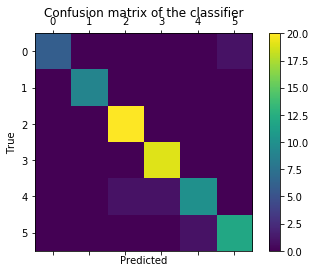

In [18]:
labels = [0,1,2,3,4,5]
cm = confusion_matrix(Test_Y, predictions_NB, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X, Train_Y)
predictions_SVM = SVM.predict(Test_X)
print("The accuracy for SVM is: ",accuracy_score(predictions_SVM, Test_Y)*100)
print(classification_report(Test_Y, predictions_SVM))

The accuracy for SVM is:  97.5
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        19
           4       0.92      1.00      0.96        12
           5       0.92      0.92      0.92        13

    accuracy                           0.97        80
   macro avg       0.97      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



In [20]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(Train_X.toarray(), Train_Y)
predictions_LDA = LDA.predict(Test_X)
print("The accuracy for LDA is: ",accuracy_score(predictions_LDA, Test_Y)*100)
print(classification_report(Test_Y, predictions_LDA))

The accuracy for LDA is:  98.75
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        12
           5       0.93      1.00      0.96        13

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.98        80
weighted avg       0.99      0.99      0.99        80



C:\Users\Bryan\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [21]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(Train_X, Train_Y)
predictions_KNN = KNN.predict(Test_X)
print("The accuracy for KNN is: ",accuracy_score(predictions_KNN, Test_Y)*100)
print(classification_report(Test_Y, predictions_KNN))

The accuracy for KNN is:  95.0
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       1.00      1.00      1.00         9
           2       1.00      0.90      0.95        20
           3       0.90      1.00      0.95        19
           4       0.92      1.00      0.96        12
           5       0.92      0.92      0.92        13

    accuracy                           0.95        80
   macro avg       0.96      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

